In [4]:
import os
import sys

In [5]:
from nnAudio import Spectrogram
wav_to_melspec = Spectrogram.MelSpectrogram(sr=16000, n_mels=80)

STFT filter created, time used = 0.0045 seconds
Mel filter created, time used = 0.0046 seconds


In [6]:
sys.path.insert(0, '/data/yinjyun/projects/constant-memory-waveglow/')

In [7]:
import numpy as np
import torch
import model.model as module_arch
from utils.util import remove_weight_norms
from train import get_instance
from librosa import load
from librosa.output import write_wav
from time import time
import json
from IPython.display import Audio, display
import matplotlib.pyplot as plt

In [8]:
resume = '/data/yinjyun/projects/constant-memory-waveglow/saved/MusicGlow/0527_131745/checkpoint-step190000.pth'
config = torch.load(resume)['config']

In [9]:
model = get_instance(module_arch, 'arch', config)
model.summary()
checkpoint = torch.load(resume)
state_dict = checkpoint['state_dict']
if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict)

if config['n_gpu'] > 1:
    model = model.module
model.apply(remove_weight_norms)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

Trainable parameters: 92202168
WaveGlow(
  (invconv1x1): ModuleList(
    (0): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (1): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (2): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (3): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (4): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (5): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (6): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (7): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (8): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (9): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (10): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (11): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (12): Inverti

WaveGlow(
  (invconv1x1): ModuleList(
    (0): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (1): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (2): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (3): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (4): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (5): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (6): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (7): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (8): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (9): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (10): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (11): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (12): InvertibleConv1x1(4, 4, kernel_size=(1

In [10]:
dur = 20
sr = config['arch']['args']['sr']

In [11]:
config['arch']['args']

{'flows': 18,
 'n_group': 8,
 'n_early_every': 6,
 'n_early_size': 2,
 'sr': 16000,
 'window_size': 2048,
 'hop_size': 512,
 'n_mels': 80,
 'dilation_channels': 256,
 'residual_channels': 256,
 'skip_channels': 256,
 'depth': 8,
 'radix': 3,
 'bias': False,
 'memory_efficient': True}

In [9]:
def inference(infile):
    y, _ = load(infile, sr=sr, duration=dur)
    print(infile)
    display(Audio(y, rate=sr))
    y = torch.Tensor(y).to(device)
    mel = model.get_mel(y[None, :])
    print(mel.shape)
    print(torch.max(mel), torch.min(mel))
    x = model.infer(mel, sigma=1.0)
    mel_hat = model.get_mel(x[None, :])
    display(Audio(x.cpu().float().numpy(), rate=sr))
    plt.close()
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(mel.squeeze(0).cpu().detach(), aspect='auto', origin='lower')
    ax[1].imshow(mel_hat.squeeze(0).cpu().detach(), aspect='auto', origin='lower')
    plt.show()

In [ ]:
metadata = json.load(open(os.path.join('/data/yinjyun/datasets/', 'maestro-v2.0.0.json')))
train_files = sorted([os.path.join('/data/yinjyun/datasets/maestro/', row['audio_filename']) 
                      for row in metadata if row['split'] == 'train'])
test_files = sorted([os.path.join('/data/yinjyun/datasets/maestro/', row['audio_filename']) 
                      for row in metadata if row['split'] == 'test'])
n_sample = 5
np.random.seed(1234)
idx_train = np.random.choice(len(train_files), n_sample, replace=False)
idx_test = np.random.choice(len(test_files), n_sample, replace=False)

In [27]:
infile = torch.Tensor(np.load("temp_1.npy")).cuda()
melspec = torch.cat([infile.squeeze(), torch.zeros(80).cuda().unsqueeze(-1)], dim=-1).detach()
print(melspec.shape)
print(torch.max(melspec), torch.min(melspec))

torch.Size([80, 626])
tensor(4.9148, device='cuda:0') tensor(-15.2776, device='cuda:0')


In [28]:
x = model.infer(melspec.unsqueeze(0), sigma=0.5)
# x = x[:-16000]

In [29]:
from nnAudio import Spectrogram
wav_to_melspec = Spectrogram.MelSpectrogram(sr=16000, n_mels=80)
melspec_gen = wav_to_melspec(x)
print(melspec_gen.shape)

STFT filter created, time used = 0.0024 seconds
Mel filter created, time used = 0.0025 seconds
torch.Size([1, 80, 627])


Generated
torch.Size([80, 626])
Inferred
torch.Size([80, 626])


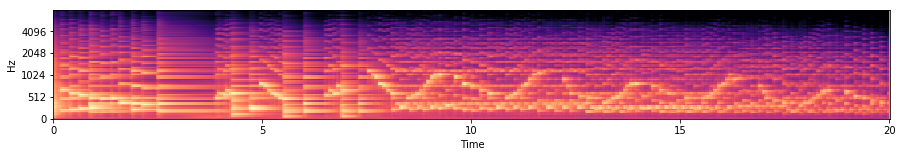

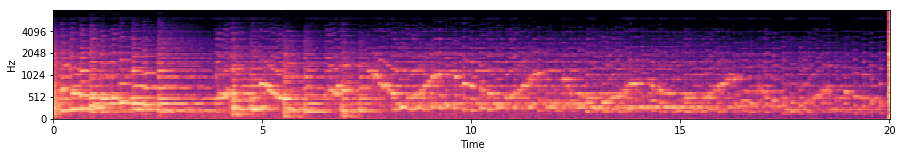

In [30]:
import matplotlib.pyplot as plt
import librosa.display

print("Generated")
plt.figure(figsize=(15,2))
melspec_denorm = torch.exp(melspec).squeeze()
print(melspec_denorm.shape)
melspec_db = librosa.power_to_db(melspec_denorm.cpu().detach().numpy().squeeze(), ref=np.max)
librosa.display.specshow(melspec_db, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)

print("Inferred")
plt.figure(figsize=(15,2))
melspec_denorm = melspec_gen.squeeze()[:, :-1]
print(melspec_denorm.shape)
melspec_db = librosa.power_to_db(melspec_denorm.cpu().detach().numpy().squeeze(), ref=np.max)
librosa.display.specshow(melspec_db, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000)

In [31]:
Audio(x[:-16000].cpu().float().numpy(), rate=sr)

In [1]:
x_denoised = denoiser(torch.Tensor(x).cuda(), 0.0015)[0][0]

NameError: name 'denoiser' is not defined

In [ ]:
# 1
Audio(x_denoised.cpu().float().numpy(), rate=sr)

In [ ]:
# 2
Audio(x.cpu().float().numpy(), rate=sr)

In [ ]:
# 3
Audio(x.cpu().float().numpy(), rate=sr)

In [ ]:
# 4
Audio(x.cpu().float().numpy(), rate=sr)

In [ ]:
# 5
Audio(x.cpu().float().numpy(), rate=sr)

In [ ]:
print("Audios from the training set")
for i in range(n_sample):
    inference(train_files[idx_train[i]])
print("Audios from the testing set")
for j in range(n_sample):
    inference(test_files[idx_test[j]])

In [ ]:
!pip install noisereduce

In [16]:
from scipy.signal import get_window
from librosa.util import normalize, pad_center, tiny
import torch.nn.functional as F
from torch.autograd import Variable

class Denoiser(torch.nn.Module):
    """ Removes model bias from audio produced with waveglow """

    def __init__(self, waveglow, filter_length=1024, n_overlap=4,
                 win_length=1024, mode='zeros'):
        super(Denoiser, self).__init__()
        self.stft = STFT(filter_length=filter_length,
                         hop_length=int(filter_length/n_overlap),
                         win_length=win_length).cuda()
        if mode == 'zeros':
            mel_input = torch.zeros(
                (1, config['arch']['args']['n_mels'], 627),
                device=device)
        elif mode == 'normal':
            mel_input = torch.randn(
                (1, config['arch']['args']['n_mels'], 627),
                device=device)
        else:
            raise Exception("Mode {} if not supported".format(mode))

        with torch.no_grad():
            bias_audio = waveglow.infer(mel_input, sigma=1.0).float()
            bias_spec, _ = self.stft.transform(bias_audio.unsqueeze(0))

        self.register_buffer('bias_spec', bias_spec[:, :, 0][:, :, None])

    def forward(self, audio, strength=0.1):
        audio_spec, audio_angles = self.stft.transform(audio.cuda().float().unsqueeze(0))
        audio_spec_denoised = audio_spec - self.bias_spec * strength
        audio_spec_denoised = torch.clamp(audio_spec_denoised, 0.0)
        audio_denoised = self.stft.inverse(audio_spec_denoised, audio_angles)
        return audio_denoised

In [17]:
class STFT(torch.nn.Module):
    """adapted from Prem Seetharaman's https://github.com/pseeth/pytorch-stft"""
    def __init__(self, filter_length=800, hop_length=200, win_length=800,
                 window='hann'):
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        scale = self.filter_length / self.hop_length
        fourier_basis = np.fft.fft(np.eye(self.filter_length))

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])
        inverse_basis = torch.FloatTensor(
            np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        if window is not None:
            assert(filter_length >= win_length)
            # get window and zero center pad it to filter_length
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = pad_center(fft_window, filter_length)
            fft_window = torch.from_numpy(fft_window).float()

            # window the bases
            forward_basis *= fft_window
            inverse_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())
        self.register_buffer('inverse_basis', inverse_basis.float())

    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        input_data = F.pad(
            input_data.unsqueeze(1),
            (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        forward_transform = F.conv1d(
            input_data,
            Variable(self.forward_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        phase = torch.autograd.Variable(
            torch.atan2(imag_part.data, real_part.data))

        return magnitude, phase

    def inverse(self, magnitude, phase):
        recombine_magnitude_phase = torch.cat(
            [magnitude*torch.cos(phase), magnitude*torch.sin(phase)], dim=1)

        inverse_transform = F.conv_transpose1d(
            recombine_magnitude_phase,
            Variable(self.inverse_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        if self.window is not None:
            window_sum = window_sumsquare(
                self.window, magnitude.size(-1), hop_length=self.hop_length,
                win_length=self.win_length, n_fft=self.filter_length,
                dtype=np.float32)
            # remove modulation effects
            approx_nonzero_indices = torch.from_numpy(
                np.where(window_sum > tiny(window_sum))[0])
            window_sum = torch.autograd.Variable(
                torch.from_numpy(window_sum), requires_grad=False)
            window_sum = window_sum.cuda() if magnitude.is_cuda else window_sum
            inverse_transform[:, :, approx_nonzero_indices] /= window_sum[approx_nonzero_indices]

            # scale by hop ratio
            inverse_transform *= float(self.filter_length) / self.hop_length

        inverse_transform = inverse_transform[:, :, int(self.filter_length/2):]
        inverse_transform = inverse_transform[:, :, :-int(self.filter_length/2):]

        return inverse_transform

    def forward(self, input_data):
        self.magnitude, self.phase = self.transform(input_data)
        reconstruction = self.inverse(self.magnitude, self.phase)
        return reconstruction

In [18]:
denoiser = Denoiser(model, 
                    config['arch']['args']['window_size'], 
                    config['arch']['args']['window_size']/config['arch']['args']['hop_size'],
                    config['arch']['args']['window_size'])